In [6]:
# !pip install contractions
# !pip install tensorflow
# !pip install transformers
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)


In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import accuracy_score, mean_absolute_error

In [43]:
import numpy as np
import pandas as pd
import tqdm
import transformers
import string
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [77]:
raw_data = pd.read_csv('/Users/yuanshenwang/Desktop/Sentiment_Analysis_of_RateMyProfessor_Reviews/data/new_data/complete_set.csv')
print(raw_data)

                                                 comment  star_rating  \
0      our final exam in dr farber art 102 class cons...          1.0   
1      my last review wa taken down for unknown reaso...          1.0   
2      i have written a review of thi professor befor...          1.0   
3      i went into thi class super excit to analyz so...          1.0   
4      thi class involv a lot of memor and will take ...          3.0   
...                                                  ...          ...   
35042  she is a veri attent and effect teacher in my ...          5.0   
35043  it the most interest class i have ever taken i...          5.0   
35044  all you will need is elizabeth note amaz struc...          3.5   
35045  waaaaay better than britten take hi cours he g...          4.5   
35046  he is veri smartwitti understand and help alwa...          3.5   

       course_difficulty  gives_good_feedback  caring  respected  \
0                    5.0                    0       0  

In [90]:
X = raw_data['comment']
y = raw_data.drop('comment', axis=1)
# y = raw_data[['star_rating','course_difficulty']]

In [91]:
print("Sample of input data (X):")
for i in range(5):  # Print first 5 comments
    print(f"Comment {i+1}: {X[i][:100]}...")

Sample of input data (X):
Comment 1: our final exam in dr farber art 102 class consist of memor everi singl detail of a 70 page studi gui...
Comment 2: my last review wa taken down for unknown reason nevertheless i had dr faber and i have to agre with ...
Comment 3: i have written a review of thi professor befor but for some reason it wa never post odd consid it wa...
Comment 4: i went into thi class super excit to analyz some renaiss art and discuss theme of enlighten and so o...
Comment 5: thi class involv a lot of memor and will take up a lot of time onc final and midterm start class is ...


In [92]:
X = raw_data['comment']
# y = raw_data[['Star_Rating', 'Course_Difficulty']]

In [93]:
max_words = 10000
max_len = 142 # max comment length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [95]:
target_columns = y.columns.tolist()
print(target_columns)

['star_rating', 'course_difficulty', 'gives_good_feedback', 'caring', 'respected', 'participation_matters', 'clear_grading_criteria', 'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class', 'lecture_heavy', 'extra_credit', 'graded_by_few_things', 'group_projects', 'would_take_again', 'skip_class_you_wont_pass', 'test_heavy', 'so_many_papers', 'beware_of_pop_quizzes', 'tests_are_tough']


In [96]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = max_len

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)
lstm_layer1 = LSTM(64, return_sequences=True)(embedding_layer)
lstm_layer2 = LSTM(32)(lstm_layer1)
dense_layer = Dense(64, activation='relu')(lstm_layer2)
dropout_layer = Dropout(0.5)(dense_layer)

outputs = []
for column in target_columns:
    if y[column].dtype == 'float64':
        # For continuous variables (like 'student_star' and 'student_difficult')
        outputs.append(Dense(1, name=column)(dropout_layer))
    else:
        # For binary variables (assuming 0 or 1)
        outputs.append(Dense(1, activation='sigmoid', name=column)(dropout_layer))

model = Model(inputs=input_layer, outputs=outputs)

In [85]:
# from keras.layers import Input, Embedding, LSTM, Dense, Dropout
# from keras.models import Model

# embedding_dim = max_len

# input_layer = Input(shape=(max_len,))
# embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)
# lstm_layer1 = LSTM(64, return_sequences=True)(embedding_layer)
# lstm_layer2 = LSTM(32)(lstm_layer1)
# dense_layer = Dense(64, activation='relu')(lstm_layer2)
# dropout_layer = Dropout(0.5)(dense_layer)

# outputs = []
# for column in target_columns:
#     if y[column].dtype == 'float64':
#         # Continuous variables
#         outputs.append(Dense(1, name=column)(dropout_layer))
#     else:
#         # Binary variables
#         outputs.append(Dense(1, activation='sigmoid', name=column)(dropout_layer))

# model = Model(inputs=input_layer, outputs=outputs)


In [118]:
losses = ['mse' if y[col].dtype == 'float64' else 'BinaryFocalCrossentropy' for col in target_columns]
metrics = []

for col in target_columns:
    if y[col].dtype == 'float64':
        metrics.append(tf.keras.metrics.MeanAbsoluteError(name=f'{col}_mae'))
    else:
        metrics.append(tf.keras.metrics.Recall(name=f'{col}_recall'))

# Compile the model with the updated losses and metrics
model.compile(
    optimizer='adam',
    loss=losses,
    loss_weights=[1.0] * len(target_columns),
    metrics=metrics
)


In [119]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 142)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 142, 142)  │  2,806,062 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 142, 64)   │     52,992 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 32)        │     12,416 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      2,112 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ star_rating (Dense) │ (None, 1)         │         65 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ course_difficulty   │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gives_good_feedback │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caring (Dense)      │ (None, 1)         │         65 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ respected (Dense)   │ (None, 1)         │         65 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ participation_matt… │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clear_grading_crit… │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ amazing_lectures    │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inspirational       │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tough_grader        │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hilarious (Dense)   │ (None, 1)         │         65 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_ready_to_read   │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lots_of_homework    │ (None, 1)         │         65 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,875,142 (10.97 MB)

 Trainable params: 2,875,142 (10.97 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
history = model.fit(
    X_train,
    [y_train[col] for col in y_train.columns],
    epochs=1,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

701/701 ━━━━━━━━━━━━━━━━━━━━ 135s 153ms/step - accessible_outside_class_accessible_outside_class_recall: 0.0000e+00 - accessible_outside_class_loss: 0.1027 - amazing_lectures_amazing_lectures_recall: 0.0706 - amazing_lectures_loss: 0.0920 - beware_of_pop_quizzes_beware_of_pop_quizzes_recall: 0.0000e+00 - beware_of_pop_quizzes_loss: 0.0470 - caring_caring_recall: 0.0693 - caring_loss: 0.1022 - clear_grading_criteria_clear_grading_criteria_recall: 0.0000e+00 - clear_grading_criteria_loss: 0.0931 - course_difficulty_course_difficulty_mae: 0.6507 - course_difficulty_loss: 0.6798 - extra_credit_extra_credit_recall: 0.0000e+00 - extra_credit_loss: 0.0557 - get_ready_to_read_get_ready_to_read_recall: 9.9704e-04 - get_ready_to_read_loss: 0.1330 - gives_good_feedback_gives_good_feedback_recall: 0.0000e+00 - gives_good_feedback_loss: 0.1024 - graded_by_few_things_graded_by_few_things_recall: 0.0000e+00 - graded_by_few_things_loss: 0.1250 - group_projects_group_projects_recall: 0.0000e+00 - group

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, recall_score, precision_score, f1_score, accuracy_score

# Predict on the test set
y_pred = model.predict(X_test)

# Create a list to store the results
results = []
thresholds = np.arange(0.29, 0.30, 0.01)  # Thresholds from 0.2 to 0.3 with 0.01 increments

# Iterate over each threshold and calculate the F1-score for classification tasks
for threshold in thresholds:
    threshold_results = []
    for i, col in enumerate(y_test.columns):
        if y_test[col].dtype == 'float64':
            # For regression tasks, calculate Mean Absolute Error
            mae = mean_absolute_error(y_test[col], y_pred[i])
            threshold_results.append({
                'Output': col,
                'Threshold': threshold,
                'Mean Absolute Error': mae,
                'Recall': None,
                'Precision': None,
                'F1-Score': None,
                'Accuracy': None
            })
        else:
            # For binary classification tasks, calculate Recall, Precision, F1-Score, and Accuracy
            y_pred_binary = (y_pred[i] > threshold).astype(int)
            recall = recall_score(y_test[col], y_pred_binary)
            precision = precision_score(y_test[col], y_pred_binary)
            f1 = f1_score(y_test[col], y_pred_binary)
            accuracy = accuracy_score(y_test[col], y_pred_binary)

            threshold_results.append({
                'Output': col,
                'Threshold': threshold,
                'Mean Absolute Error': None,
                'Recall': recall,
                'Precision': precision,
                'F1-Score': f1,
                'Accuracy': accuracy
            })
    results.extend(threshold_results)

# Create the DataFrame from the results list
performance_df = pd.DataFrame(results)

# Display the results
print("Model Performance for Different Thresholds:")
print(performance_df.to_string(index=False))

# Calculate and display average F1-Score for each threshold
print("\nAverage F1-Score for Different Thresholds:")
for threshold in thresholds:
    avg_f1 = performance_df[(performance_df['Threshold'] == threshold) & (performance_df['F1-Score'].notna())]['F1-Score'].mean()
    print(f"Threshold {threshold:.2f}: Average F1-Score = {avg_f1:.4f}")

# Calculate and display average MAE for regression tasks
regression_mae = performance_df['Mean Absolute Error'].mean()
print(f"\nAverage Regression MAE: {regression_mae:.4f}")


220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step


/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Model Performance for Different Thresholds:
                  Output  Threshold  Mean Absolute Error   Recall  Precision  F1-Score  Accuracy
             star_rating       0.20             0.607398      NaN        NaN       NaN       NaN
       course_difficulty       0.20             0.805254      NaN        NaN       NaN       NaN
     gives_good_feedback       0.20                  NaN 0.957105   0.220280  0.358134  0.452354
                  caring       0.20                  NaN 0.969489   0.255940  0.404971  0.467190
               respected       0.20                  NaN 0.940577   0.232236  0.372500  0.467475
   participation_matters       0.20                  NaN 1.000000   0.139658  0.245087  0.139658
  clear_grading_criteria       0.20                  NaN 0.935523   0.151318  0.260501  0.377175
        amazing_lectures       0.20                  NaN 0.947819   0.256126  0.403276  0.532240
           inspirational       0.20                  NaN 0.921212   0.152572  0.261

/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuanshenwang/miniconda3/envs/544/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Model Performance for Different Thresholds:
                  Output  Threshold  Mean Absolute Error   Recall  Precision  F1-Score  Accuracy
             star_rating        0.1             0.607398      NaN        NaN       NaN       NaN
       course_difficulty        0.1             0.805254      NaN        NaN       NaN       NaN
     gives_good_feedback        0.1                  NaN 0.980340   0.202175  0.335218  0.379315
                  caring        0.1                  NaN 0.985507   0.231417  0.374819  0.385164
               respected        0.1                  NaN 0.964346   0.213735  0.349915  0.397860
   participation_matters        0.1                  NaN 1.000000   0.139658  0.245087  0.139658
  clear_grading_criteria        0.1                  NaN 0.980535   0.135576  0.238215  0.264622
        amazing_lectures        0.1                  NaN 0.972626   0.234047  0.377302  0.464622
           inspirational        0.1                  NaN 0.957576   0.134240  0.235

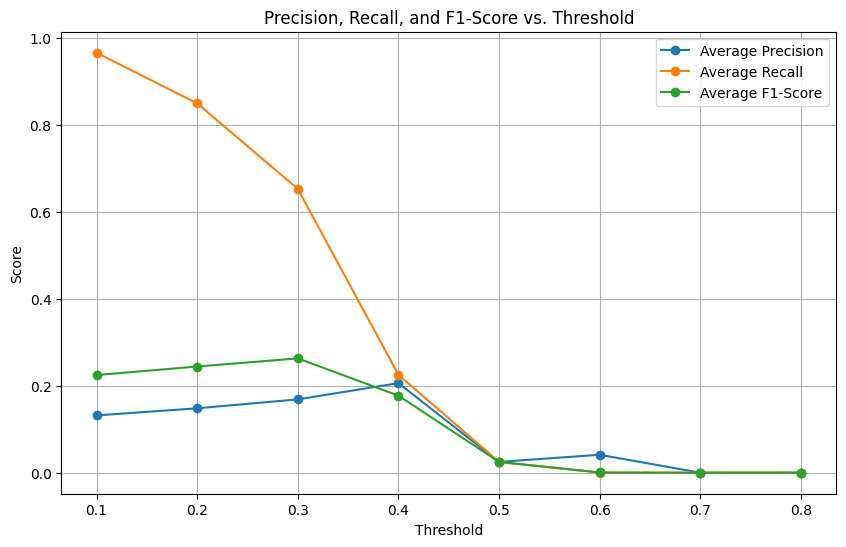

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, recall_score, precision_score, f1_score, accuracy_score

# Predict on the test set
y_pred = model.predict(X_test)

# Create a list to store the results
results = []
thresholds = np.arange(0.1, 0.9, 0.1)  # Thresholds from 0.2 to 0.3 with 0.01 increments

# Iterate over each threshold and calculate the F1-score for classification tasks
for threshold in thresholds:
    threshold_results = []
    for i, col in enumerate(y_test.columns):
        if y_test[col].dtype == 'float64':
            # For regression tasks, calculate Mean Absolute Error
            mae = mean_absolute_error(y_test[col], y_pred[i])
            threshold_results.append({
                'Output': col,
                'Threshold': threshold,
                'Mean Absolute Error': mae,
                'Recall': None,
                'Precision': None,
                'F1-Score': None,
                'Accuracy': None
            })
        else:
            # For binary classification tasks, calculate Recall, Precision, F1-Score, and Accuracy
            y_pred_binary = (y_pred[i] > threshold).astype(int)
            recall = recall_score(y_test[col], y_pred_binary)
            precision = precision_score(y_test[col], y_pred_binary)
            f1 = f1_score(y_test[col], y_pred_binary)
            accuracy = accuracy_score(y_test[col], y_pred_binary)

            threshold_results.append({
                'Output': col,
                'Threshold': threshold,
                'Mean Absolute Error': None,
                'Recall': recall,
                'Precision': precision,
                'F1-Score': f1,
                'Accuracy': accuracy
            })
    results.extend(threshold_results)

# Create the DataFrame from the results list
performance_df = pd.DataFrame(results)

# Display the results
print("Model Performance for Different Thresholds:")
print(performance_df.to_string(index=False))

# Calculate and display average F1-Score for each threshold
avg_f1_scores = []
avg_recalls = []
avg_precisions = []
avg_accuracies = []
for threshold in thresholds:
    avg_f1 = performance_df[(performance_df['Threshold'] == threshold) & (performance_df['F1-Score'].notna())]['F1-Score'].mean()
    avg_recall = performance_df[(performance_df['Threshold'] == threshold) & (performance_df['Recall'].notna())]['Recall'].mean()
    avg_precision = performance_df[(performance_df['Threshold'] == threshold) & (performance_df['Precision'].notna())]['Precision'].mean()
    avg_accuracy = performance_df[(performance_df['Threshold'] == threshold) & (performance_df['Accuracy'].notna())]['Accuracy'].mean()
    avg_f1_scores.append(avg_f1)
    avg_recalls.append(avg_recall)
    avg_precisions.append(avg_precision)
    avg_accuracies.append(avg_accuracy)
    print(f"Threshold {threshold:.2f}: Average F1-Score = {avg_f1:.4f}")

# Calculate and display average MAE for regression tasks
regression_mae = performance_df['Mean Absolute Error'].mean()
print(f"\nAverage Regression MAE: {regression_mae:.4f}")

# Plot Precision, Recall, and F1-Score against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, avg_precisions, label='Average Precision', marker='o')
plt.plot(thresholds, avg_recalls, label='Average Recall', marker='o')
plt.plot(thresholds, avg_f1_scores, label='Average F1-Score', marker='o')
plt.plot(thresholds, avg_accuracies, label='Average Accuracy', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 10.2 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.8 MB/s eta 0:00:00
